# Initialization

In [71]:
import pandas as pd
from sklearn.model_selection import train_test_split
import h5py
import numpy as np
import verstack
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import optuna
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, PowerTransformer
import joblib
from tqdm import tqdm

In [59]:
def load_data(name):
    with h5py.File(f'{name}.h5', 'r') as f:
        filename = name.split('/')[1]
        return pd.DataFrame(f[filename][:], dtype=np.float64)

train = load_data('data/train')
test = load_data('data/test')

train

,eventNumber,runNumber,actualInteractionsPerCrossing,averageInteractionsPerCrossing,correctedActualMu,correctedAverageMu,correctedScaledActualMu,correctedScaledAverageMu,NvtxReco,p_nTracks,...,p_E5x7_Lr1,p_E5x7_Lr2,p_E5x7_Lr3,p_E7x11_Lr0,p_E7x11_Lr1,p_E7x11_Lr2,p_E7x11_Lr3,p_E7x7_Lr0,p_E7x7_Lr1,index
0,87834187.0,300000.0,26.500000,26.500000,26.500000,26.500000,26.500000,26.500000,18.0,3.0,...,43402.332031,74045.820312,337.980713,273.708801,43091.683594,74447.539062,470.177124,273.708801,43091.683594,0.0
1,84862668.0,300000.0,35.500000,35.500000,35.500000,35.500000,35.500000,35.500000,23.0,4.0,...,36774.925781,58228.847656,412.321869,10861.282227,37433.324219,61805.964844,460.203613,10861.282227,37433.324219,1.0
2,20869557.0,300000.0,29.490000,29.490000,29.490000,29.490000,29.490000,29.490000,20.0,3.0,...,23413.427734,38875.042969,3492.513672,5705.863281,23728.701172,40497.234375,3333.052734,5705.863281,23728.701172,2.0
3,42161877.0,300000.0,37.500000,37.500000,37.500000,37.500000,37.500000,37.500000,17.0,2.0,...,27372.955078,104002.000000,921.178040,0.000000,27101.673828,106995.789062,1127.115356,0.000000,27101.673828,3.0
4,82761614.0,300000.0,59.500000,59.500000,59.500000,59.500000,59.500000,59.500000,33.0,7.0,...,45745.859375,87924.406250,-75.167221,0.000000,45947.109375,93710.968750,-188.182098,0.000000,45947.109375,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162495,87753440.0,300000.0,59.500000,59.500000,59.500000,59.500000,59.500000,59.500000,34.0,2.0,...,35473.875000,86889.070312,867.511475,1120.453857,36521.750000,88872.992188,748.347656,1120.453857,36521.750000,162495.0
162496,7746045.0,300000.0,11.490000,11.490000,11.490000,11.490000,11.490000,11.490000,10.0,4.0,...,36722.617188,79933.289062,352.093262,0.000000,36812.964844,83049.414062,665.589417,0.000000,36800.929688,162496.0
162497,85994391.0,300000.0,44.490002,44.490002,44.490002,44.490002,44.490002,44.490002,28.0,5.0,...,26506.359375,52808.492188,287.444580,7824.405273,26847.457031,53551.433594,-13.175649,7824.405273,26847.457031,162497.0
162498,9886827.0,300000.0,20.490000,20.490000,20.490000,20.490000,20.490000,20.490000,14.0,1.0,...,46398.742188,134187.593750,1426.328613,0.000000,46656.253906,137266.218750,1512.928101,0.000000,46656.253906,162498.0


In [60]:
all_variables = ['actualInteractionsPerCrossing', 'averageInteractionsPerCrossing', 'correctedActualMu', 'correctedAverageMu', 'correctedScaledActualMu', 'correctedScaledAverageMu', 'NvtxReco', 'p_nTracks', 'p_pt_track', 'p_eta', 'p_phi', 'p_charge', 'p_qOverP', 'p_z0', 'p_d0', 'p_sigmad0', 'p_d0Sig', 'p_EptRatio', 'p_dPOverP', 'p_z0theta', 'p_etaCluster', 'p_phiCluster', 'p_eCluster', 'p_rawEtaCluster', 'p_rawPhiCluster', 'p_rawECluster', 'p_eClusterLr0', 'p_eClusterLr1', 'p_eClusterLr2', 'p_eClusterLr3', 'p_etaClusterLr1', 'p_etaClusterLr2', 'p_phiClusterLr2', 'p_eAccCluster', 'p_f0Cluster', 'p_etaCalo', 'p_phiCalo', 'p_eTileGap3Cluster', 'p_cellIndexCluster', 'p_phiModCalo', 'p_etaModCalo', 'p_dPhiTH3', 'p_R12', 'p_fTG3', 'p_weta2', 'p_Reta', 'p_Rphi', 'p_Eratio', 'p_f1', 'p_f3', 'p_Rhad', 'p_Rhad1', 'p_deltaEta1', 'p_deltaPhiRescaled2', 'p_TRTPID', 'p_TRTTrackOccupancy', 'p_numberOfInnermostPixelHits', 'p_numberOfPixelHits', 'p_numberOfSCTHits', 'p_numberOfTRTHits', 'p_numberOfTRTXenonHits', 'p_chi2', 'p_ndof', 'p_SharedMuonTrack', 'p_E7x7_Lr2', 'p_E7x7_Lr3', 'p_E_Lr0_HiG', 'p_E_Lr0_LowG', 'p_E_Lr0_MedG', 'p_E_Lr1_HiG', 'p_E_Lr1_LowG', 'p_E_Lr1_MedG', 'p_E_Lr2_HiG', 'p_E_Lr2_LowG', 'p_E_Lr2_MedG', 'p_E_Lr3_HiG', 'p_E_Lr3_LowG', 'p_E_Lr3_MedG', 'p_ambiguityType', 'p_asy1', 'p_author', 'p_barys1', 'p_core57cellsEnergyCorrection', 'p_deltaEta0', 'p_deltaEta2', 'p_deltaEta3', 'p_deltaPhi0', 'p_deltaPhi1', 'p_deltaPhi2', 'p_deltaPhi3', 'p_deltaPhiFromLastMeasurement', 'p_deltaPhiRescaled0', 'p_deltaPhiRescaled1', 'p_deltaPhiRescaled3', 'p_e1152', 'p_e132', 'p_e235', 'p_e255', 'p_e2ts1', 'p_ecore', 'p_emins1', 'p_etconeCorrBitset', 'p_ethad', 'p_ethad1', 'p_f1core', 'p_f3core', 'p_maxEcell_energy', 'p_maxEcell_gain', 'p_maxEcell_time', 'p_maxEcell_x', 'p_maxEcell_y', 'p_maxEcell_z', 'p_nCells_Lr0_HiG', 'p_nCells_Lr0_LowG', 'p_nCells_Lr0_MedG', 'p_nCells_Lr1_HiG', 'p_nCells_Lr1_LowG', 'p_nCells_Lr1_MedG', 'p_nCells_Lr2_HiG', 'p_nCells_Lr2_LowG', 'p_nCells_Lr2_MedG', 'p_nCells_Lr3_HiG', 'p_nCells_Lr3_LowG', 'p_nCells_Lr3_MedG', 'p_pos', 'p_pos7', 'p_poscs1', 'p_poscs2', 'p_ptconeCorrBitset', 'p_ptconecoreTrackPtrCorrection', 'p_r33over37allcalo', 'p_topoetconeCorrBitset', 'p_topoetconecoreConeEnergyCorrection', 'p_topoetconecoreConeSCEnergyCorrection', 'p_weta1', 'p_widths1', 'p_widths2', 'p_wtots1', 'p_e233', 'p_e237', 'p_e277', 'p_e2tsts1', 'p_ehad1', 'p_emaxs1', 'p_fracs1', 'p_DeltaE', 'p_E3x5_Lr0', 'p_E3x5_Lr1', 'p_E3x5_Lr2', 'p_E3x5_Lr3', 'p_E5x7_Lr0', 'p_E5x7_Lr1', 'p_E5x7_Lr2', 'p_E5x7_Lr3', 'p_E7x11_Lr0', 'p_E7x11_Lr1', 'p_E7x11_Lr2', 'p_E7x11_Lr3', 'p_E7x7_Lr0', 'p_E7x7_Lr1' ]

electron_variables = ['actualInteractionsPerCrossing','averageInteractionsPerCrossing','correctedActualMu','correctedAverageMu','correctedScaledActualMu','correctedScaledAverageMu','NvtxReco','p_nTracks','p_pt_track','p_eta','p_phi','p_charge','p_qOverP','p_z0','p_d0','p_sigmad0','p_d0Sig','p_EptRatio','p_dPOverP','p_z0theta','p_etaCluster','p_phiCluster','p_eCluster','p_rawEtaCluster','p_rawPhiCluster','p_rawECluster','p_eClusterLr0','p_eClusterLr1','p_eClusterLr2','p_eClusterLr3','p_etaClusterLr1','p_etaClusterLr2','p_phiClusterLr2','p_eAccCluster','p_f0Cluster','p_etaCalo','p_phiCalo','p_eTileGap3Cluster','p_cellIndexCluster','p_phiModCalo','p_etaModCalo','p_dPhiTH3','p_R12','p_fTG3','p_weta2','p_Reta','p_Rphi','p_Eratio','p_f1','p_f3','p_Rhad','p_Rhad1','p_deltaEta1','p_deltaPhiRescaled2','p_TRTPID','p_TRTTrackOccupancy','p_numberOfInnermostPixelHits','p_numberOfPixelHits','p_numberOfSCTHits','p_numberOfTRTHits','p_numberOfTRTXenonHits','p_chi2','p_ndof','p_SharedMuonTrack','p_E7x7_Lr2','p_E7x7_Lr3','p_E_Lr0_HiG','p_E_Lr0_LowG','p_E_Lr0_MedG','p_E_Lr1_HiG','p_E_Lr1_LowG','p_E_Lr1_MedG','p_E_Lr2_HiG','p_E_Lr2_LowG','p_E_Lr2_MedG','p_E_Lr3_HiG','p_E_Lr3_LowG','p_E_Lr3_MedG','p_ambiguityType','p_asy1','p_author','p_barys1','p_core57cellsEnergyCorrection','p_deltaEta0','p_deltaEta2','p_deltaEta3','p_deltaPhi0','p_deltaPhi1','p_deltaPhi2','p_deltaPhi3','p_deltaPhiFromLastMeasurement','p_deltaPhiRescaled0','p_deltaPhiRescaled1','p_deltaPhiRescaled3','p_e1152','p_e132','p_e235','p_e255','p_e2ts1','p_ecore','p_emins1','p_etconeCorrBitset','p_ethad','p_ethad1','p_f1core','p_f3core','p_maxEcell_energy','p_maxEcell_gain','p_maxEcell_time','p_maxEcell_x','p_maxEcell_y','p_maxEcell_z','p_nCells_Lr0_HiG','p_nCells_Lr0_LowG','p_nCells_Lr0_MedG','p_nCells_Lr1_HiG','p_nCells_Lr1_LowG','p_nCells_Lr1_MedG','p_nCells_Lr2_HiG','p_nCells_Lr2_LowG','p_nCells_Lr2_MedG','p_nCells_Lr3_HiG','p_nCells_Lr3_LowG','p_nCells_Lr3_MedG','p_pos','p_pos7','p_poscs1','p_poscs2','p_ptconeCorrBitset','p_ptconecoreTrackPtrCorrection','p_r33over37allcalo','p_topoetconeCorrBitset','p_topoetconecoreConeEnergyCorrection','p_topoetconecoreConeSCEnergyCorrection','p_weta1','p_widths1','p_widths2','p_wtots1','p_e233','p_e237','p_e277','p_e2tsts1','p_ehad1','p_emaxs1','p_fracs1','p_DeltaE','p_E3x5_Lr0','p_E3x5_Lr1','p_E3x5_Lr2','p_E3x5_Lr3','p_E5x7_Lr0','p_E5x7_Lr1','p_E5x7_Lr2','p_E5x7_Lr3','p_E7x11_Lr0','p_E7x11_Lr1','p_E7x11_Lr2','p_E7x11_Lr3','p_E7x7_Lr0','p_E7x7_Lr1']

# X = train[all_variables]
X = train[electron_variables]
y = train['Truth']

## Classification with verstack

In [61]:
obj = verstack.LGBMTuner(metric='accuracy', visualization=True)
obj.fit(X, y)


 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 100 trials
     .. Evaluation metric: accuracy 
     .. Study direction: minimize log_loss



KeyboardInterrupt: 

In [ ]:
obj.predict_proba(test[all_variables])

array([0.99673276, 0.98708088, 0.99483253, ..., 0.04102004, 0.00353447,
       0.9975751 ])

In [ ]:
opt_features = list(obj.feature_importances.sort_values(ascending=False)[:15].index)
obj.feature_importances.sort_values(ascending=False)[:15]

p_deltaPhiRescaled2               0.03163
p_ptconecoreTrackPtrCorrection    0.02642
p_deltaEta1                       0.02516
p_d0Sig                           0.02388
p_d0                              0.02313
p_sigmad0                         0.02295
p_Rphi                            0.02183
p_dPOverP                         0.02113
p_deltaPhiFromLastMeasurement     0.02098
p_Reta                            0.02097
p_deltaPhi2                       0.01482
p_EptRatio                        0.01457
p_TRTPID                          0.01421
p_deltaEta2                       0.01392
p_E7x11_Lr3                       0.01337
dtype: float64

In [ ]:
obj.best_params

{'task': 'train',
 'learning_rate': 0.04,
 'num_leaves': 183,
 'colsample_bytree': 0.8671516207368498,
 'subsample': 0.7318460107239373,
 'bagging_freq': 1,
 'max_depth': -1,
 'verbosity': -1,
 'reg_alpha': 0.00025758441629384563,
 'reg_lambda': 0.3142699396328412,
 'min_split_gain': 0.0,
 'zero_as_missing': False,
 'max_bin': 255,
 'min_data_in_bin': 3,
 'random_state': 42,
 'device_type': 'cpu',
 'num_classes': 1,
 'objective': 'binary',
 'metric': 'binary_logloss',
 'num_threads': 14,
 'min_sum_hessian_in_leaf': 0.24868362348057776,
 'n_estimators': 304}

## XGBoost with Optuna

### Finding best features

In [ ]:
input_train, input_valid, truth_train, truth_valid = train_test_split(X, y, train_size=0.9, random_state=42)


XGB = XGBClassifier(learning_rate=0.1, n_estimators=300, seed=42)
XGB.fit(input_train, truth_train)

XGB.score(input_valid, truth_valid)

0.9441846153846154

In [ ]:
a, b = zip(*sorted(zip(XGB.feature_importances_, X.columns), reverse=True))
xgb_opt_features = list(b[:15])
xgb_opt_features

['p_Rhad',
 'p_ethad',
 'p_ambiguityType',
 'p_numberOfInnermostPixelHits',
 'p_Rhad1',
 'p_sigmad0',
 'p_Reta',
 'p_Rphi',
 'p_ethad1',
 'p_nTracks',
 'p_deltaEta1',
 'p_ehad1',
 'p_deltaPhiRescaled2',
 'p_numberOfPixelHits',
 'p_e2tsts1']

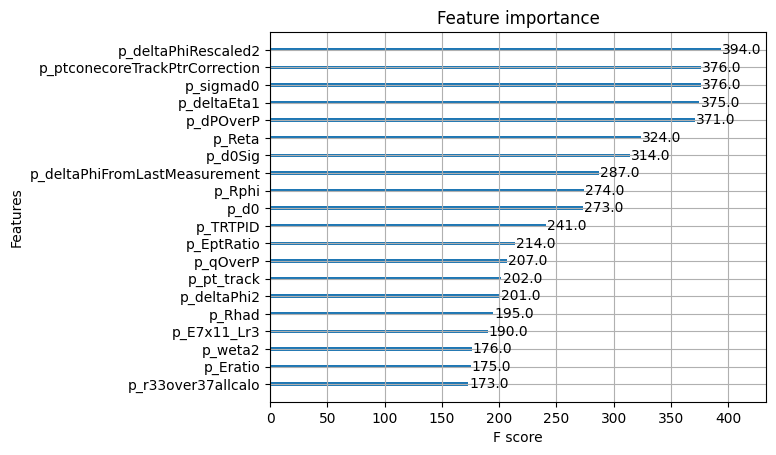

In [ ]:
import xgboost

xgboost.plot_importance(XGB, max_num_features=20);

In [ ]:
input_train, input_valid, truth_train, truth_valid = train_test_split(X[xgb_opt_features], y, train_size=0.9, random_state=42)


XGB = XGBClassifier(learning_rate=0.1, n_estimators=300, seed=42, eval_metric='logloss')
XGB.fit(input_train, truth_train)

tf.losses.binary_crossentropy(truth_valid, XGB.predict_proba(input_valid)[:,1]).numpy()

0.16864051

### Hyperparameter optimization

In [ ]:
import optuna
from xgboost import XGBClassifier

def objective(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }

    # Fit the model
    optuna_model = XGBClassifier(**params)
    optuna_model.fit(input_train, truth_train)

    # Make and evaluate predictions
    predictions = optuna_model.predict_proba(input_valid)[:,1]

    return tf.losses.binary_crossentropy(truth_valid, predictions).numpy()


In [ ]:
# study = optuna.create_study(direction='minimize')
study = joblib.load('data/optuna_xgb_classification.study')

study.optimize(objective, n_trials=100)
joblib.dump(study, 'data/optuna_xgb_classification.study')



print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2023-05-19 13:15:04,215] A new study created in memory with name: no-name-3cc196b5-2d01-421f-9eb9-3dfe560a64ad
[I 2023-05-19 13:15:08,341] Trial 0 finished with value: 0.24678528308868408 and parameters: {'max_depth': 7, 'learning_rate': 0.3191063603954425, 'n_estimators': 317, 'min_child_weight': 4, 'gamma': 0.029786987918874134, 'subsample': 0.013687655291496426, 'colsample_bytree': 0.06781066385399058, 'reg_alpha': 1.2308861862825144e-08, 'reg_lambda': 0.00029140618207125745}. Best is trial 0 with value: 0.24678528308868408.
[I 2023-05-19 13:15:15,577] Trial 1 finished with value: 0.18584996461868286 and parameters: {'max_depth': 5, 'learning_rate': 0.4066839585107456, 'n_estimators': 248, 'min_child_weight': 5, 'gamma': 8.762377396882683e-07, 'subsample': 0.7485262222452924, 'colsample_bytree': 0.10024677720856534, 'reg_alpha': 0.01657415661043735, 'reg_lambda': 2.3480951074196163e-05}. Best is trial 1 with value: 0.18584996461868286.
[I 2023-05-19 13:15:19,469] Trial 2 finished

Number of finished trials: 100
Best trial:
  Value: 0.16660818457603455
  Params: 
    max_depth: 9
    learning_rate: 0.0237538176361407
    n_estimators: 498
    min_child_weight: 4
    gamma: 2.2703433591971862e-06
    subsample: 0.5412550333578701
    colsample_bytree: 0.5627792454863988
    reg_alpha: 0.006667955868867927
    reg_lambda: 1.1900106480488672e-05


In [ ]:
params = trial.params
model = XGBClassifier(**params)
model.fit(input_train, truth_train)

tf.losses.binary_crossentropy(truth_valid, model.predict_proba(input_valid)[:,1]).numpy(), model.score(input_valid, truth_valid)

(0.16660818, 0.9389538461538461)

## Neural Network

In [ ]:
from scipy import stats

X[(np.abs(stats.zscore(X)) < 100000).all(axis=1)]

,actualInteractionsPerCrossing,averageInteractionsPerCrossing,correctedActualMu,correctedAverageMu,correctedScaledActualMu,correctedScaledAverageMu,NvtxReco,p_nTracks,p_pt_track,p_eta,...,p_E5x7_Lr0,p_E5x7_Lr1,p_E5x7_Lr2,p_E5x7_Lr3,p_E7x11_Lr0,p_E7x11_Lr1,p_E7x11_Lr2,p_E7x11_Lr3,p_E7x7_Lr0,p_E7x7_Lr1


In [ ]:
X[opt_features].describe()

,p_deltaPhiRescaled2,p_ptconecoreTrackPtrCorrection,p_d0Sig,p_deltaEta1,p_sigmad0,p_d0,p_Rphi,p_dPOverP,p_deltaPhiFromLastMeasurement,p_Reta,p_pt_track,p_EptRatio,p_deltaPhi2,p_TRTPID,p_deltaEta2
count,162500.000000,1.625000e+05,162500.000000,162500.000000,162500.000000,162500.000000,162500.000000,162500.000000,162500.000000,162500.000000,1.625000e+05,162500.000000,162500.000000,162500.000000,162500.000000
mean,-0.053935,3.016883e+04,-0.070421,-0.013556,0.043753,-0.006978,0.906449,0.401223,-14.555532,0.909008,3.767370e+04,3.103862,-0.011305,0.170403,0.000009
std,8.518389,8.611457e+05,8.006779,5.460531,0.254252,1.018138,0.074041,0.410308,119.636867,0.069805,6.398419e+05,6.421212,0.038727,0.342043,0.006926
min,-1297.900879,0.000000e+00,-818.559814,-2201.196533,0.007177,-37.931423,0.000000,-4.000000,-999.000000,-0.006000,3.916667e+02,0.000207,-0.699607,-0.776530,-0.117263
25%,-0.001807,1.479927e+04,-0.804442,-0.001106,0.015823,-0.017091,0.894428,0.178630,-0.015548,0.911298,1.579378e+04,1.003030,-0.007918,-0.000000,-0.000844
50%,0.000585,2.560676e+04,0.005717,-0.000047,0.020408,0.000111,0.933293,0.356191,-0.004097,0.930191,2.871401e+04,1.315141,-0.001657,-0.000000,-0.000014
75%,0.003874,3.466562e+04,0.817545,0.001013,0.032620,0.017175,0.949513,0.667787,-0.000501,0.943325,3.907144e+04,2.393792,0.000547,0.312053,0.000820
max,0.497833,3.448992e+08,592.257996,0.210166,90.347443,40.379303,4.815775,0.999977,2.698916,1.342384,2.347504e+08,122.654770,0.143387,2.295614,0.091991


In [ ]:
X['p_deltaPhiRescaled2'].describe()

count    162500.000000
mean         -0.053935
std           8.518389
min       -1297.900879
25%          -0.001807
50%           0.000585
75%           0.003874
max           0.497833
Name: p_deltaPhiRescaled2, dtype: float64

In [ ]:
X['p_deltaPhiRescaled2'].sort_values().head(25)

33679    -1297.900879
34869    -1297.900879
20646    -1297.900879
155143   -1297.900879
116653   -1297.900879
148007   -1297.900879
76369    -1297.900879
123736      -0.215086
6803        -0.213220
157036      -0.207897
67488       -0.206812
49141       -0.196149
137803      -0.184515
17696       -0.180961
114612      -0.178811
106078      -0.175046
37144       -0.170164
127113      -0.168639
140169      -0.168555
86985       -0.168202
90139       -0.162976
55336       -0.158422
157644      -0.156339
20296       -0.156261
8061        -0.155460
Name: p_deltaPhiRescaled2, dtype: float64

In [ ]:
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()

X_transform = scalar.fit_transform(X[opt_features], y)

X_transform = pd.DataFrame(X_transform, columns=opt_features)
X_transform

,p_deltaPhiRescaled2,p_ptconecoreTrackPtrCorrection,p_d0Sig,p_d0,p_Rphi,p_sigmad0,p_deltaEta1,p_deltaPhiFromLastMeasurement,p_dPOverP,p_EptRatio,p_deltaPhi2,p_deltaEta2,p_pt_track,p_Reta,p_Rhad
0,0.006426,0.009479,-0.134149,-0.009058,0.714613,-0.116413,0.002355,0.121671,0.347367,-0.335423,0.314450,-0.079966,0.006780,0.572616,-0.568892
1,0.006213,-0.035033,-0.030214,-0.003540,-0.890548,-0.038829,0.002845,0.121227,1.249101,-0.301229,0.239895,0.240462,0.003203,0.334776,-0.377888
2,0.007730,-0.009795,0.058110,0.013914,0.355243,-0.100487,-0.000756,0.121680,-0.858713,-0.227031,0.350068,-1.108373,-0.029578,0.151158,1.095771
3,0.006419,0.002417,0.250881,0.034135,0.604344,-0.115726,0.002758,0.121668,0.932135,-0.359674,0.332537,0.027773,0.011411,0.593225,-0.206606
4,0.006834,-0.008708,0.113295,0.032800,-0.514635,-0.047909,0.002081,0.121574,-0.561015,0.015854,0.029598,0.008955,-0.041757,0.356821,-0.091531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162495,0.006308,-0.006177,0.005695,0.006406,0.646735,-0.099811,0.002505,0.121641,0.221901,-0.326596,0.286182,0.113479,0.003521,0.264425,-0.287926
162496,0.007724,-0.023412,-0.432893,-0.238479,-0.367933,0.105709,0.002508,0.121421,-0.452487,0.602914,-0.480647,-0.114682,-0.051062,0.467257,-0.385115
162497,0.005693,0.001605,0.082503,0.014745,0.987240,-0.118545,0.002329,0.121626,0.361059,-0.335308,0.192597,0.130713,0.000093,0.613371,-0.232564
162498,-0.000383,-0.035033,0.410370,0.253203,0.610350,0.134723,-0.011399,0.119892,1.363972,1.150174,-1.588511,-5.074924,-0.053241,0.101479,-0.294926


### Trying with robust scaler

In [138]:
opt_features = ['p_deltaPhiRescaled2'           ,                'p_ptconecoreTrackPtrCorrection',                'p_deltaEta1',                'p_d0Sig'    ,                'p_d0'       ,                'p_sigmad0'  , 'p_Rphi'     ,                'p_dPOverP'  ,                'p_deltaPhiFromLastMeasurement' , 'p_Reta'     ,                'p_deltaPhi2',                'p_EptRatio' ,                'p_TRTPID'   ,                'p_deltaEta2',                'p_E7x11_Lr3',]

In [143]:
from sklearn.preprocessing import RobustScaler

scalar = RobustScaler(quantile_range=[10, 90])

X_transform = scalar.fit_transform(X, y)

X_transform = pd.DataFrame(X_transform, columns=X.columns)
X_transform.describe()

,actualInteractionsPerCrossing,averageInteractionsPerCrossing,correctedActualMu,correctedAverageMu,correctedScaledActualMu,correctedScaledAverageMu,NvtxReco,p_nTracks,p_pt_track,p_eta,...,p_E5x7_Lr0,p_E5x7_Lr1,p_E5x7_Lr2,p_E5x7_Lr3,p_E7x11_Lr0,p_E7x11_Lr1,p_E7x11_Lr2,p_E7x11_Lr3,p_E7x7_Lr0,p_E7x7_Lr1
count,162500.000000,162500.000000,162500.000000,162500.000000,162500.000000,162500.000000,162500.000000,162500.000000,162500.000000,162500.000000,...,162500.000000,162500.000000,162500.000000,162500.000000,162500.000000,162500.000000,162500.000000,162500.000000,162500.000000,162500.000000
mean,0.051215,0.051215,0.051215,0.051215,0.051215,0.051215,0.049154,0.040617,0.213350,0.337249,...,0.273562,0.052838,0.029434,0.343646,0.274471,0.056077,0.032016,0.311065,0.274484,0.055824
std,0.374037,0.374037,0.374037,0.374037,0.374037,0.374037,0.375676,0.385396,15.236089,0.441079,...,0.446771,0.404668,0.384988,1.372793,0.447478,0.406884,0.388360,1.174616,0.447672,0.406800
min,-0.771429,-0.771429,-0.771429,-0.771429,-0.771429,-0.771429,-1.058824,-0.400000,-0.674419,-0.210453,...,-0.117883,-1.105615,-0.815868,-1.040523,-0.205151,-1.109523,-0.813243,-0.768002,-0.205314,-1.109111
25%,-0.228571,-0.228571,-0.228571,-0.228571,-0.228571,-0.228571,-0.235294,-0.200000,-0.307660,-0.095769,...,0.000000,-0.221951,-0.258327,-0.093131,0.000000,-0.221065,-0.256195,-0.092703,0.000000,-0.220928
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.285714,0.285714,0.285714,0.285714,0.285714,0.285714,0.294118,0.200000,0.246634,0.772442,...,0.507138,0.281821,0.267835,0.174307,0.507923,0.284289,0.268171,0.179054,0.507518,0.283829
max,1.285714,1.285714,1.285714,1.285714,1.285714,1.285714,2.000000,3.000000,5589.254860,0.886467,...,6.432760,9.816392,9.178283,50.530107,6.804657,9.778825,11.134975,40.487494,6.810072,9.785795


In [144]:
from sklearn.model_selection import train_test_split

input_train, input_valid, truth_train, truth_valid = train_test_split(X_transform, y, train_size=0.8)

In [147]:
# model = Sequential([
#     Dense(len(input_train.columns),activation='relu',name='input_layer'),
#     Dense(50,activation='relu',name='hidden_layer1'),
#     Dense(20,activation='relu',name='hidden_layer2'),
#     Dense(10,activation='relu',name='hidden_layer3'),
#     Dense(1, activation='sigmoid', name='output')])
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
#               loss=tf.keras.losses.BinaryCrossentropy(),
#               metrics=[tf.keras.metrics.Accuracy()])

# print('--------- TRAINING ---------')
# history = model.fit(x = np.array(input_train), 
#                     y = np.array(truth_train), 
#                     validation_data=(np.array(input_valid), np.array(truth_valid)), 
#                     epochs = 200,
#                     batch_size=1024,
#                     callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True)])  

model = Sequential([
    Dense(76,activation='relu',name='hidden_layer1'),
    Dense(64,activation='relu',name='hidden_layer2'),
    Dense(1, activation='sigmoid', name='output')])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002618239735357655),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.Accuracy()])

print('--------- TRAINING ---------')
history = model.fit(x = np.array(input_train), 
                    y = np.array(truth_train), 
                    validation_data=(np.array(input_valid), np.array(truth_valid)), 
                    epochs = 200,
                    batch_size=1024,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True)])  

--------- TRAINING ---------
Epoch 1/200
127/127 [==============================] - 1s 5ms/step - loss: 2.0404 - accuracy: 0.0331 - val_loss: 0.4873 - val_accuracy: 0.0150
Epoch 2/200
127/127 [==============================] - 0s 4ms/step - loss: 1.2455 - accuracy: 0.0272 - val_loss: 1.0172 - val_accuracy: 0.0131
Epoch 3/200
127/127 [==============================] - 0s 4ms/step - loss: 0.8607 - accuracy: 0.0213 - val_loss: 0.7424 - val_accuracy: 0.0600
Epoch 4/200
127/127 [==============================] - 0s 4ms/step - loss: 0.7302 - accuracy: 0.0290 - val_loss: 0.4775 - val_accuracy: 0.0133
Epoch 5/200
127/127 [==============================] - 0s 4ms/step - loss: 0.5575 - accuracy: 0.0194 - val_loss: 0.4473 - val_accuracy: 0.0150
Epoch 6/200
127/127 [==============================] - 0s 4ms/step - loss: 0.4884 - accuracy: 0.0199 - val_loss: 0.2502 - val_accuracy: 0.0032
Epoch 7/200
127/127 [==============================] - 0s 4ms/step - loss: 0.3765 - accuracy: 0.0110 - val_loss: 

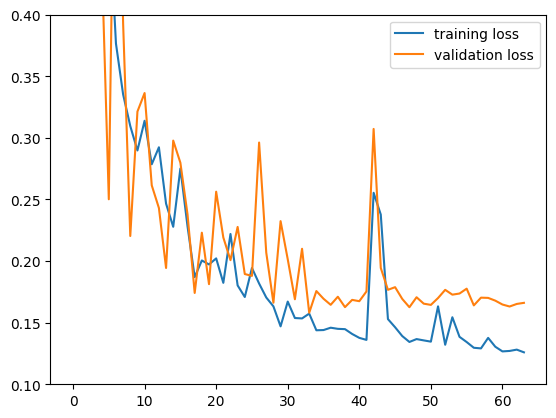

In [148]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.ylim(0.1, 0.4)
plt.legend();

### Permutation Importance

In [149]:
init_loss = tf.keras.losses.binary_crossentropy(truth_valid.values, model.predict(input_valid)[:, 0]).numpy()
repeat = 1
importances = np.zeros(len(input_valid.columns))

for i in range(repeat):
    importance_list = []
    for col in tqdm(input_valid.columns):
        shuffled_df = input_valid.copy()
        shuffled_df[col] = shuffled_df[col].sample(frac=1).values
        predictions = model.predict(shuffled_df, verbose=0)[:,0]
        new_loss = tf.keras.losses.binary_crossentropy(truth_valid.values, predictions).numpy()
        importance_list.append((new_loss - init_loss) / init_loss)
    importances += np.array(importance_list)

importances /= repeat

importance_df = pd.DataFrame({"imp":importances, "col":input_valid.columns})
# importance_df['imp'] = importance_df['imp'].apply(abs)
# importance_df.sort_values('imp')
importance_df = importance_df.reindex(importance_df['imp'].abs().sort_values(ascending=False).index)
importance_df

1016/1016 [==============================] - 1s 621us/step


100%|██████████| 160/160 [02:15<00:00,  1.18it/s]


,imp,col
135,8.408646,p_widths1
79,5.872667,p_asy1
134,5.813272,p_weta1
124,4.541508,p_pos
126,1.571149,p_poscs1
...,...,...
136,0.000000,p_widths2
76,0.000000,p_E_Lr3_LowG
128,0.000000,p_ptconeCorrBitset
131,0.000000,p_topoetconeCorrBitset


In [100]:
tf_opt_features = importance_df['col'][:15].values
tf_opt_features

array(['p_weta1', 'p_widths1', 'p_asy1', 'p_pos', 'p_poscs1', 'p_pos7',
       'p_wtots1', 'p_ethad', 'p_E7x11_Lr3', 'p_deltaEta1', 'p_sigmad0',
       'p_deltaPhi2', 'p_barys1', 'p_d0Sig', 'p_E_Lr3_MedG'], dtype=object)

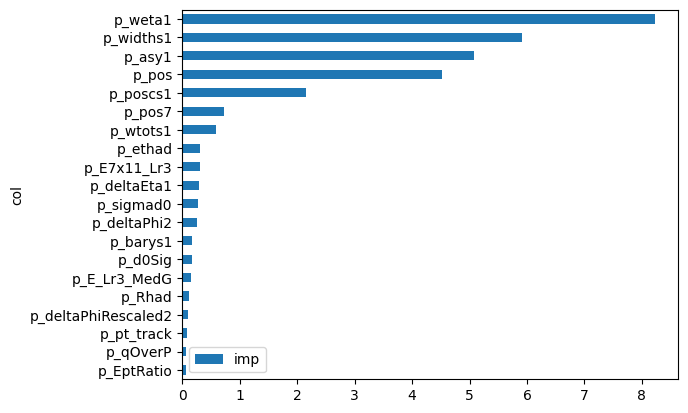

In [101]:
ax = importance_df[:20].plot.barh('col', 'imp')
ax.invert_yaxis()

### SHAP values

In [104]:
import shap

shap.initjs()

shap_rows = shap.sample(input_valid, 512)

# explainer = shap.KernelExplainer(model, input_valid)
# shap_values = explainer.shap_values(input_valid)
explainer = shap.DeepExplainer(model, np.array(input_valid))
shap_values = explainer.shap_values(np.array(shap_rows))

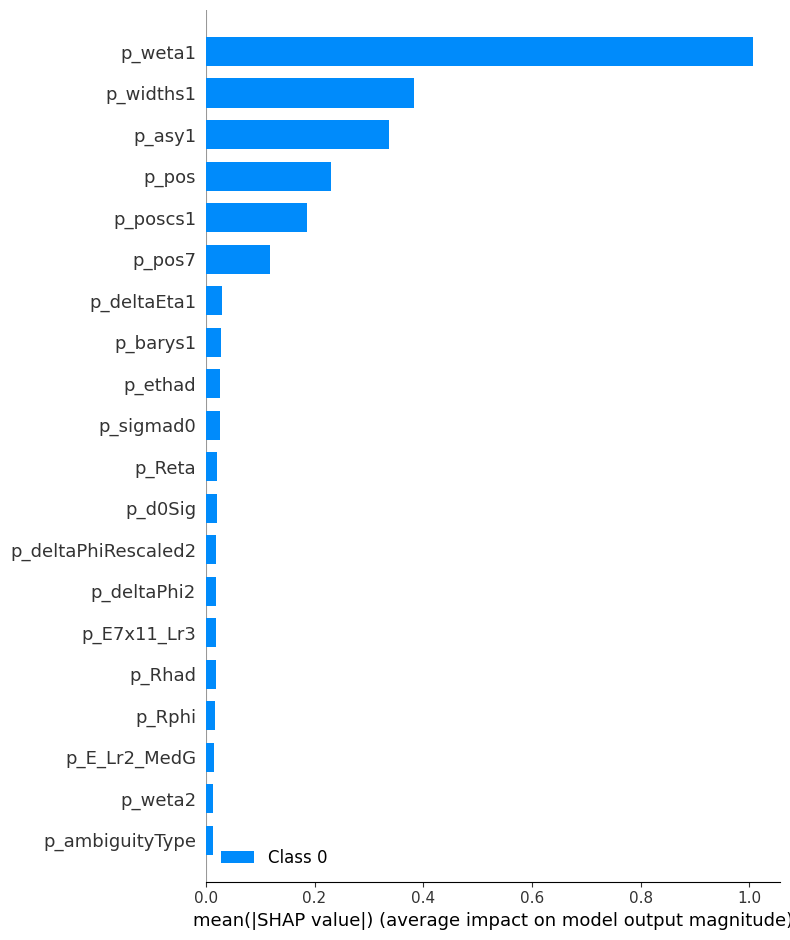

In [105]:
shap.summary_plot(shap_values, input_valid, plot_type="bar")

In [124]:
a,b = zip(*sorted(zip(np.mean(shap_values, axis=1)[0], input_valid.columns)))
tf_opt_features = list(b[:15])
tf_opt_features

['p_weta1',
 'p_pt_track',
 'p_pos7',
 'p_sigmad0',
 'p_nCells_Lr1_HiG',
 'p_phi',
 'p_dPOverP',
 'p_numberOfSCTHits',
 'p_etaCluster',
 'p_maxEcell_gain',
 'p_etaClusterLr2',
 'p_E7x7_Lr1',
 'p_etaCalo',
 'p_etaClusterLr1',
 'p_maxEcell_z']

### Trying optuna

In [141]:
from sklearn.preprocessing import RobustScaler

scalar = RobustScaler(quantile_range=[10, 90])

X_transform = scalar.fit_transform(X[tf_opt_features], y)

X_transform = pd.DataFrame(X_transform, columns=tf_opt_features)

input_train, input_valid, truth_train, truth_valid = train_test_split(X_transform, y, train_size=0.8)

input_train

,p_weta1,p_pt_track,p_pos7,p_sigmad0,p_nCells_Lr1_HiG,p_phi,p_dPOverP,p_numberOfSCTHits,p_etaCluster,p_maxEcell_gain,p_etaClusterLr2,p_E7x7_Lr1,p_etaCalo,p_etaClusterLr1,p_maxEcell_z
161928,0.070920,0.135946,0.009074,-0.096463,0.208333,-0.549061,-0.126445,0.000000,0.739787,1.0,0.739642,0.062656,0.738517,0.739699,0.990228
21669,-0.114421,0.176005,0.141892,-0.075726,-0.444444,0.292034,0.024688,0.666667,-0.119682,1.0,-0.119466,0.227355,-0.120273,-0.119989,-0.006876
143570,-0.111598,0.144106,-0.181338,-0.033489,-0.208333,0.342013,0.342684,-0.333333,0.809700,1.0,0.809997,0.677075,0.808856,0.809296,0.988325
85990,-0.058200,-0.316622,0.119072,1.003541,0.180556,0.232384,0.654458,-0.333333,-0.068646,1.0,-0.068606,0.107893,-0.069027,-0.068842,-0.007339
64942,-0.020776,-0.137747,-0.042192,0.016540,-0.194444,0.397110,-0.048537,0.000000,0.821259,0.0,0.821436,0.731838,0.820399,0.820930,0.988053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98021,-0.258564,0.006482,-0.219225,-0.093152,-0.402778,0.546502,-0.393420,-0.333333,-0.149925,1.0,-0.149776,0.096584,-0.150344,-0.150183,-0.005163
151811,0.238270,-0.436745,-0.417146,0.067163,0.611111,-0.074693,-0.305806,0.000000,0.727822,0.0,0.727086,-0.508342,0.726792,0.729188,0.990221
100304,-0.193657,0.134257,-0.036838,-0.016357,0.208333,-0.524638,0.190133,0.333333,-0.095203,1.0,-0.095095,-0.010934,-0.095349,-0.095422,-0.007331
115978,0.594115,-0.388060,0.894067,0.042799,0.611111,0.212416,0.014915,0.666667,0.687939,0.0,0.689257,-0.072943,0.686695,0.686889,0.991950


In [129]:
def objective(trial):
  n_layers = trial.suggest_int("n_layers", 1, 4)
  model = tf.keras.Sequential()
  # model.add(Dense(len(input_train.columns),activation='relu',name='input_layer'))  # I think keras automatically does this?
  for i in range(n_layers):
    num_hidden = trial.suggest_int("n_units_l{}".format(i), 1, 128, log=True)
    model.add(Dense(num_hidden, activation="relu"))
  model.add(Dense(1, activation='sigmoid', name='output'))

  lr = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
  model.compile(tf.optimizers.Adam(learning_rate=lr),
                tf.losses.BinaryCrossentropy())
  history = model.fit(x = np.array(input_train), 
                      y = np.array(truth_train), 
                      validation_data=(np.array(input_valid), np.array(truth_valid)), 
                      epochs = 200,
                      batch_size=1024,
                      callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True)],
                      verbose = 0)  
  return np.min(history.history['val_loss'])

In [131]:
# study = optuna.create_study(direction='minimize')
study = joblib.load('data/optuna_tf_classification.study')

study.optimize(objective, n_trials=100, show_progress_bar=True)
joblib.dump(study, 'data/optuna_tf_classification.study')

print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

100%|██████████| 100/100 [1:27:27<00:00, 52.48s/it]

Number of finished trials: 100
Best trial:
  Value: 0.29893362522125244
  Params: 
    n_layers: 2
    n_units_l0: 76
    n_units_l1: 64
    learning_rate: 0.002056138865204246


I don't know why, but using `tf_opt_features` is way way worse than just using `opt_features`.

--------- TRAINING ---------
Epoch 1/200
127/127 [==============================] - 1s 4ms/step - loss: 2.3733 - accuracy: 0.0267 - val_loss: 2.9446 - val_accuracy: 0.0438
Epoch 2/200
127/127 [==============================] - 0s 3ms/step - loss: 1.3558 - accuracy: 0.0253 - val_loss: 1.6913 - val_accuracy: 1.2308e-04
Epoch 3/200
127/127 [==============================] - 0s 3ms/step - loss: 1.3314 - accuracy: 0.0271 - val_loss: 0.7063 - val_accuracy: 0.0452
Epoch 4/200
127/127 [==============================] - 0s 3ms/step - loss: 1.3196 - accuracy: 0.0251 - val_loss: 1.1328 - val_accuracy: 1.2308e-04
Epoch 5/200
127/127 [==============================] - 0s 3ms/step - loss: 1.3278 - accuracy: 0.0285 - val_loss: 1.5783 - val_accuracy: 0.0439
Epoch 6/200
127/127 [==============================] - 0s 3ms/step - loss: 0.8047 - accuracy: 0.0183 - val_loss: 0.5883 - val_accuracy: 0.0291
Epoch 7/200
127/127 [==============================] - 0s 3ms/step - loss: 0.9344 - accuracy: 0.0239 - va

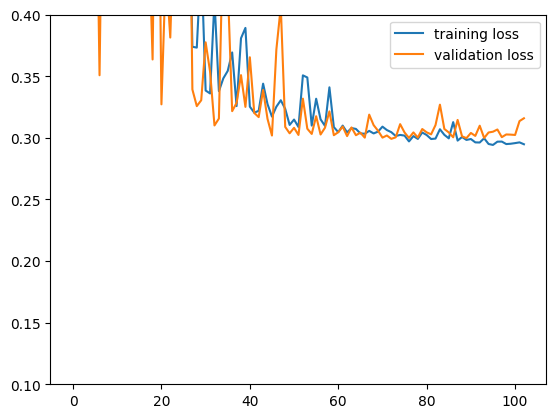

In [142]:
model = Sequential([
    Dense(76,activation='relu',name='hidden_layer1'),
    Dense(64,activation='relu',name='hidden_layer2'),
    Dense(1, activation='sigmoid', name='output')])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002056138865204246),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.Accuracy()])

print('--------- TRAINING ---------')
history = model.fit(x = np.array(input_train), 
                    y = np.array(truth_train), 
                    validation_data=(np.array(input_valid), np.array(truth_valid)), 
                    epochs = 200,
                    batch_size=1024,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True)])  

plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.ylim(0.1, 0.4)
plt.legend();

# Regression

In [ ]:
X_e = train[train['Truth'] == 1][electron_variables]
y_e = train[train['Truth'] == 1]['p_truth_E']
X_e

,actualInteractionsPerCrossing,averageInteractionsPerCrossing,correctedActualMu,correctedAverageMu,correctedScaledActualMu,correctedScaledAverageMu,NvtxReco,p_nTracks,p_pt_track,p_eta,...,p_E5x7_Lr0,p_E5x7_Lr1,p_E5x7_Lr2,p_E5x7_Lr3,p_E7x11_Lr0,p_E7x11_Lr1,p_E7x11_Lr2,p_E7x11_Lr3,p_E7x7_Lr0,p_E7x7_Lr1
0,26.500000,26.500000,26.500000,26.500000,26.500000,26.500000,18.0,3.0,42011.792969,1.834715,...,215.588013,43402.332031,74045.820312,337.980713,273.708801,43091.683594,74447.539062,470.177124,273.708801,43091.683594
3,37.500000,37.500000,37.500000,37.500000,37.500000,37.500000,17.0,2.0,44975.042969,-2.023659,...,0.000000,27372.955078,104002.000000,921.178040,0.000000,27101.673828,106995.789062,1127.115356,0.000000,27101.673828
4,59.500000,59.500000,59.500000,59.500000,59.500000,59.500000,33.0,7.0,10956.218750,2.069837,...,0.000000,45745.859375,87924.406250,-75.167221,0.000000,45947.109375,93710.968750,-188.182098,0.000000,45947.109375
7,35.500000,35.500000,35.500000,35.500000,35.500000,35.500000,20.0,5.0,24223.316406,1.984269,...,0.000000,39245.539062,75593.671875,1672.360107,0.000000,39520.097656,77926.218750,2248.715820,0.000000,39520.097656
11,44.490002,44.490002,44.490002,44.490002,44.490002,44.490002,26.0,1.0,33938.906250,2.044807,...,0.000000,32873.839844,81557.367188,184.990524,0.000000,32153.529297,83021.085938,-274.701904,0.000000,32153.529297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162493,35.500000,35.500000,35.500000,35.500000,35.500000,35.500000,18.0,7.0,37901.839844,1.783071,...,9658.285156,49876.812500,85073.117188,2255.361328,9959.162109,50938.000000,90556.890625,4368.040039,9959.162109,50938.000000
162494,34.490002,34.490002,34.490002,34.490002,34.490002,34.490002,21.0,3.0,20513.746094,-2.246926,...,0.000000,70740.851562,83686.460938,-424.531433,0.000000,70654.773438,86513.257812,-587.068237,0.000000,70654.773438
162495,59.500000,59.500000,59.500000,59.500000,59.500000,59.500000,34.0,2.0,39926.601562,-1.856813,...,1064.037109,35473.875000,86889.070312,867.511475,1120.453857,36521.750000,88872.992188,748.347656,1120.453857,36521.750000
162496,11.490000,11.490000,11.490000,11.490000,11.490000,11.490000,10.0,4.0,5002.065430,1.953580,...,0.000000,36722.617188,79933.289062,352.093262,0.000000,36812.964844,83049.414062,665.589417,0.000000,36800.929688


In [ ]:
y_e.sort_values()

90459       2462.046143
133307      2506.251221
132518      2512.538574
17286       3020.244141
95044       3274.316895
              ...      
90457     314317.406250
99479     315013.843750
33907     323969.875000
55749     414221.937500
43861     478980.312500
Name: p_truth_E, Length: 121495, dtype: float64

## Neural Network, Optuna

In [ ]:
scalerX = RobustScaler(quantile_range=[10, 90]).fit(X_e)
scalerY = StandardScaler().fit(np.array(y_e).reshape(-1, 1))

X_e_transform = scalerX.transform(X_e)
y_e_transform = scalerY.transform(np.array(y_e).reshape(-1, 1))
# y_e_transform = y_e_transform[:, 0]

X_e_transform = pd.DataFrame(X_e_transform, columns=X_e.columns)

input_train, input_valid, truth_train, truth_valid = train_test_split(X_e_transform, y_e_transform, train_size=0.8)

In [ ]:
def objective(trial):
  n_layers = trial.suggest_int("n_layers", 1, 4)
  model = tf.keras.Sequential()
  # model.add(Dense(len(input_train.columns),activation='relu',name='input_layer'))  # I think keras automatically does this?
  for i in range(n_layers):
    num_hidden = trial.suggest_int("n_units_l{}".format(i), 1, 128, log=True)
    model.add(Dense(num_hidden, activation="relu"))
  model.add(Dense(1, activation='sigmoid', name='output'))

  lr = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
  model.compile(tf.optimizers.Adam(learning_rate=lr),
                tf.losses.MAE)
  history = model.fit(x = np.array(input_train), 
                      y = np.array(truth_train), 
                      validation_data=(np.array(input_valid), np.array(truth_valid)), 
                      epochs = 200,
                      batch_size=1024,
                      callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True)],
                      verbose = 0)  
  return np.min(history.history['val_loss'])

In [ ]:
# study = optuna.create_study(direction='minimize')
study = joblib.load('data/optuna_tf_regression.study')

study.optimize(objective, n_trials=100)
joblib.dump(study, 'data/optuna_tf_regression.study')

print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2023-05-18 14:54:15,478] A new study created in memory with name: no-name-0723a9a4-4aa1-4bfb-9779-a2385d640834
[I 2023-05-18 14:54:42,190] Trial 0 finished with value: 0.8172543048858643 and parameters: {'n_layers': 4, 'n_units_l0': 45, 'n_units_l1': 57, 'n_units_l2': 11, 'n_units_l3': 1, 'learning_rate': 0.08504492249929872}. Best is trial 0 with value: 0.8172543048858643.
[I 2023-05-18 14:54:59,973] Trial 1 finished with value: 0.5592190027236938 and parameters: {'n_layers': 4, 'n_units_l0': 1, 'n_units_l1': 1, 'n_units_l2': 1, 'n_units_l3': 23, 'learning_rate': 0.0018545559066010854}. Best is trial 1 with value: 0.5592190027236938.
[I 2023-05-18 14:55:03,764] Trial 2 finished with value: 0.6062803864479065 and parameters: {'n_layers': 2, 'n_units_l0': 1, 'n_units_l1': 7, 'learning_rate': 0.010994581542784107}. Best is trial 1 with value: 0.5592190027236938.
[I 2023-05-18 14:55:13,201] Trial 3 finished with value: 0.6055339574813843 and parameters: {'n_layers': 3, 'n_units_l0': 27

Number of finished trials: 100
Best trial:
  Value: 0.5542223453521729
  Params: 
    n_layers: 3
    n_units_l0: 8
    n_units_l1: 17
    n_units_l2: 86
    learning_rate: 0.004351925324399445


In [ ]:
model = Sequential([
    Dense(50,activation='relu',name='hidden_layer1'),
    Dense(20,activation='relu',name='hidden_layer2'),
    Dense(10,activation='relu',name='hidden_layer3'),
    Dense(1, activation='sigmoid', name='output')])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss=tf.keras.metrics.MAE,
              metrics=[tf.keras.metrics.MSE])

print('--------- TRAINING ---------')
history = model.fit(x = np.array(input_train), 
                    y = np.array(truth_train), 
                    validation_data=(np.array(input_valid), np.array(truth_valid)), 
                    epochs = 200,
                    batch_size=1024,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True)])  


--------- TRAINING ---------
Epoch 1/200
95/95 [==============================] - 1s 3ms/step - loss: 0.9425 - mean_squared_error: 1.2398 - val_loss: 0.9173 - val_mean_squared_error: 1.1711
Epoch 2/200
95/95 [==============================] - 0s 2ms/step - loss: 0.8847 - mean_squared_error: 1.1011 - val_loss: 0.8454 - val_mean_squared_error: 1.0055
Epoch 3/200
95/95 [==============================] - 0s 2ms/step - loss: 0.8010 - mean_squared_error: 0.9218 - val_loss: 0.7556 - val_mean_squared_error: 0.8269
Epoch 4/200
95/95 [==============================] - 0s 2ms/step - loss: 0.7111 - mean_squared_error: 0.7548 - val_loss: 0.6748 - val_mean_squared_error: 0.6878
Epoch 5/200
95/95 [==============================] - 0s 2ms/step - loss: 0.6506 - mean_squared_error: 0.6575 - val_loss: 0.6334 - val_mean_squared_error: 0.6288
Epoch 6/200
95/95 [==============================] - 0s 2ms/step - loss: 0.6197 - mean_squared_error: 0.6172 - val_loss: 0.6109 - val_mean_squared_error: 0.6028
Epoch

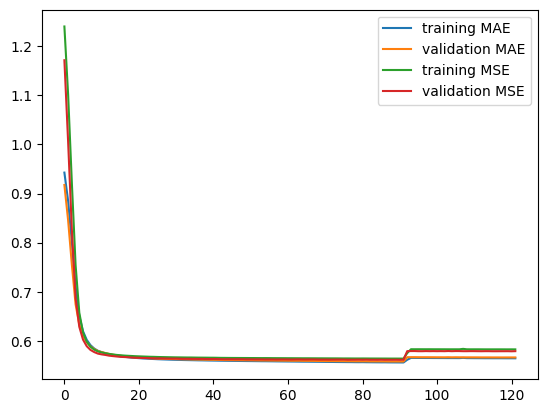

In [ ]:
plt.plot(history.history['loss'], label='training MAE')
plt.plot(history.history['val_loss'], label='validation MAE')
plt.plot(history.history['mean_squared_error'], label='training MSE')
plt.plot(history.history['val_mean_squared_error'], label='validation MSE')
plt.legend();

# Dimensionality Reduction

## UMAP

### Untransformed data

UMAP( verbose=True)
Wed May 17 16:46:17 2023 Construct fuzzy simplicial set
Wed May 17 16:46:18 2023 Finding Nearest Neighbors
Wed May 17 16:46:18 2023 Building RP forest with 25 trees
Wed May 17 16:46:23 2023 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	Stopping threshold met -- exiting after 3 iterations
Wed May 17 16:46:42 2023 Finished Nearest Neighbor Search
Wed May 17 16:46:46 2023 Construct embedding


Epochs completed: 100%| ██████████ 200/200 [00:22]


Wed May 17 16:47:25 2023 Finished embedding


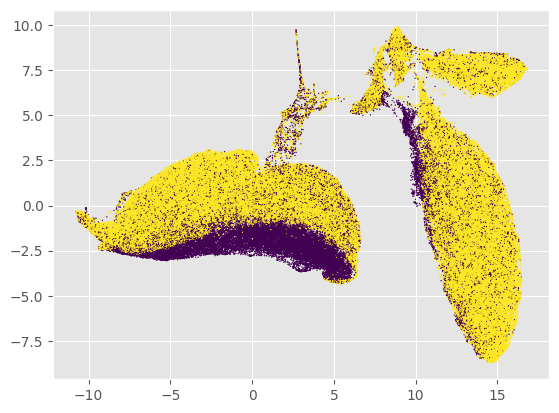

In [ ]:
import umap
import matplotlib.pyplot as plt

# running UMAP
# use the non-standardized data X[:, flux_idxs]
map_obj = umap.UMAP(verbose=True)
y_umap = map_obj.fit_transform(X)

plt.scatter(y_umap[:,0], y_umap[:, 1], c=y.values, s=0.2)

### Transformed data with `StandardScaler`

UMAP( verbose=True)
Wed May 17 11:28:29 2023 Construct fuzzy simplicial set
Wed May 17 11:28:29 2023 Finding Nearest Neighbors
Wed May 17 11:28:29 2023 Building RP forest with 25 trees
Wed May 17 11:28:31 2023 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	 4  /  17
	Stopping threshold met -- exiting after 4 iterations
Wed May 17 11:28:34 2023 Finished Nearest Neighbor Search
Wed May 17 11:28:35 2023 Construct embedding


Epochs completed: 100%| ██████████ 200/200 [00:24]


Wed May 17 11:29:16 2023 Finished embedding


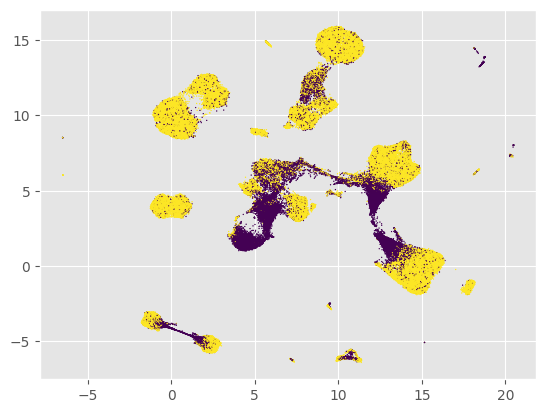

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_transform = scaler.fit_transform(X, y)

X_transform = pd.DataFrame(X_transform, columns=X.columns)

map_obj = umap.UMAP(verbose=True)
y_umap = map_obj.fit_transform(X_transform)

plt.scatter(y_umap[:,0], y_umap[:, 1], c=y.values, s=0.2)

### Transformed data with `RobustScaler`

UMAP( verbose=True)
Wed May 17 16:47:29 2023 Construct fuzzy simplicial set
Wed May 17 16:47:29 2023 Finding Nearest Neighbors
Wed May 17 16:47:29 2023 Building RP forest with 25 trees
Wed May 17 16:47:30 2023 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	 4  /  17
	Stopping threshold met -- exiting after 4 iterations
Wed May 17 16:47:33 2023 Finished Nearest Neighbor Search
Wed May 17 16:47:34 2023 Construct embedding


Epochs completed: 100%| ██████████ 200/200 [00:24]


Wed May 17 16:48:13 2023 Finished embedding


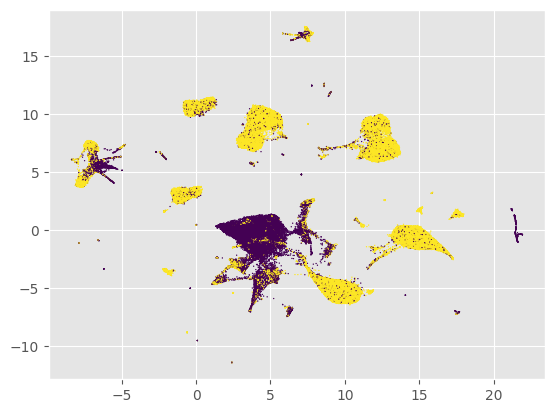

In [ ]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler(quantile_range=[10, 90])

X_transform = scaler.fit_transform(X, y)

X_transform = pd.DataFrame(X_transform, columns=X.columns)

map_obj = umap.UMAP(verbose=True)
y_umap = map_obj.fit_transform(X_transform)

plt.scatter(y_umap[:,0], y_umap[:, 1], c=y.values, s=0.2)

### Transformed data with `QuantileTransformer`

UMAP( verbose=True)
Wed May 17 11:23:52 2023 Construct fuzzy simplicial set
Wed May 17 11:23:53 2023 Finding Nearest Neighbors
Wed May 17 11:23:53 2023 Building RP forest with 25 trees
Wed May 17 11:23:54 2023 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	 4  /  17
	 5  /  17
	Stopping threshold met -- exiting after 5 iterations
Wed May 17 11:23:58 2023 Finished Nearest Neighbor Search
Wed May 17 11:23:58 2023 Construct embedding


Epochs completed: 100%| ██████████ 200/200 [00:25]


Wed May 17 11:24:41 2023 Finished embedding


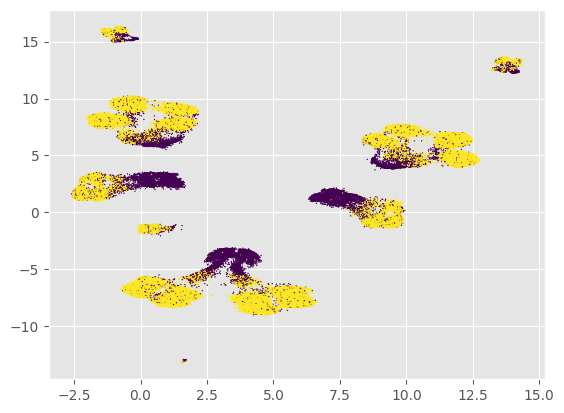

In [ ]:
from sklearn.preprocessing import QuantileTransformer

scaler = QuantileTransformer()

X_transform = scaler.fit_transform(X, y)

X_transform = pd.DataFrame(X_transform, columns=X.columns)

map_obj = umap.UMAP(verbose=True)
y_umap = map_obj.fit_transform(X_transform)

plt.scatter(y_umap[:,0], y_umap[:, 1], c=y.values, s=0.2)

### Transformed data with `PowerTransformer`

UMAP( verbose=True)
Wed May 17 11:26:44 2023 Construct fuzzy simplicial set
Wed May 17 11:26:44 2023 Finding Nearest Neighbors
Wed May 17 11:26:44 2023 Building RP forest with 25 trees
Wed May 17 11:26:46 2023 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	 3  /  17
	 4  /  17
	 5  /  17
	Stopping threshold met -- exiting after 5 iterations
Wed May 17 11:26:49 2023 Finished Nearest Neighbor Search
Wed May 17 11:26:50 2023 Construct embedding


Epochs completed: 100%| ██████████ 200/200 [00:25]


Wed May 17 11:27:33 2023 Finished embedding


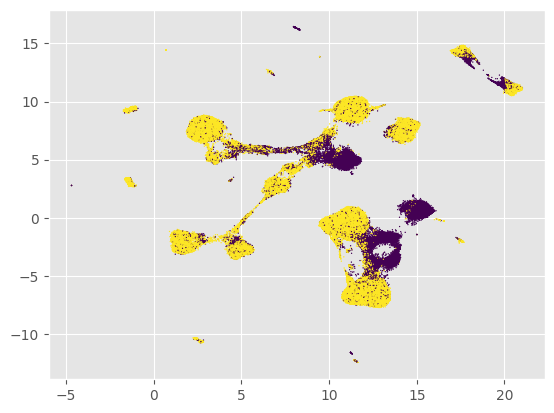

In [ ]:
from sklearn.preprocessing import PowerTransformer

scaler = PowerTransformer()

X_transform = scaler.fit_transform(X, y)

X_transform = pd.DataFrame(X_transform, columns=X.columns)

map_obj = umap.UMAP(verbose=True)
y_umap = map_obj.fit_transform(X_transform)

plt.scatter(y_umap[:,0], y_umap[:, 1], c=y.values, s=0.2)

## t-SNE

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 162500 samples in 0.092s...
[t-SNE] Computed neighbors for 162500 samples in 33.532s...
[t-SNE] Computed conditional probabilities for sample 1000 / 162500
[t-SNE] Computed conditional probabilities for sample 2000 / 162500
[t-SNE] Computed conditional probabilities for sample 3000 / 162500
[t-SNE] Computed conditional probabilities for sample 4000 / 162500
[t-SNE] Computed conditional probabilities for sample 5000 / 162500
[t-SNE] Computed conditional probabilities for sample 6000 / 162500
[t-SNE] Computed conditional probabilities for sample 7000 / 162500
[t-SNE] Computed conditional probabilities for sample 8000 / 162500
[t-SNE] Computed conditional probabilities for sample 9000 / 162500
[t-SNE] Computed conditional probabilities for sample 10000 / 162500
[t-SNE] Computed conditional probabilities for sample 11000 / 162500
[t-SNE] Computed conditional probabilities for sample 12000 / 162500
[t-SNE] Computed conditional probab

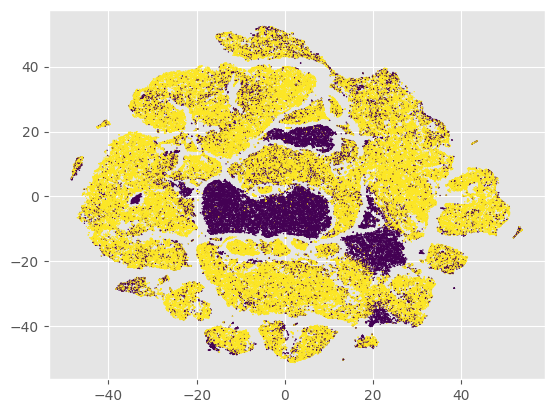

In [ ]:
from sklearn.manifold import TSNE

# running t-SNE
# use the non-standardized data X[:, flux_idxs]
tsne = TSNE(verbose=2)
y_tsne = tsne.fit_transform(X)

plt.scatter(y_tsne[:,0], y_tsne[:, 1], c=y.values, s=0.2)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 162500 samples in 0.101s...
[t-SNE] Computed neighbors for 162500 samples in 33.655s...
[t-SNE] Computed conditional probabilities for sample 1000 / 162500
[t-SNE] Computed conditional probabilities for sample 2000 / 162500
[t-SNE] Computed conditional probabilities for sample 3000 / 162500
[t-SNE] Computed conditional probabilities for sample 4000 / 162500
[t-SNE] Computed conditional probabilities for sample 5000 / 162500
[t-SNE] Computed conditional probabilities for sample 6000 / 162500
[t-SNE] Computed conditional probabilities for sample 7000 / 162500
[t-SNE] Computed conditional probabilities for sample 8000 / 162500
[t-SNE] Computed conditional probabilities for sample 9000 / 162500
[t-SNE] Computed conditional probabilities for sample 10000 / 162500
[t-SNE] Computed conditional probabilities for sample 11000 / 162500
[t-SNE] Computed conditional probabilities for sample 12000 / 162500
[t-SNE] Computed conditional probab

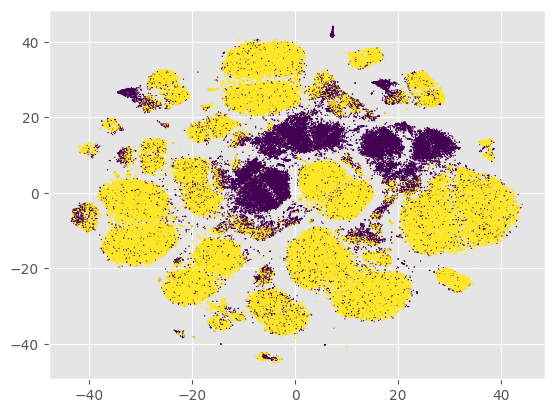

In [ ]:
from sklearn.manifold import TSNE


scaler = PowerTransformer()

X_transform = scaler.fit_transform(X, y)

X_transform = pd.DataFrame(X_transform, columns=X.columns)

# running t-SNE
# use the non-standardized data X[:, flux_idxs]
tsne = TSNE(verbose=1)
y_tsne = tsne.fit_transform(X_transform)

plt.scatter(y_tsne[:,0], y_tsne[:, 1], c=y.values, s=0.2)


# Clustering

## k-means

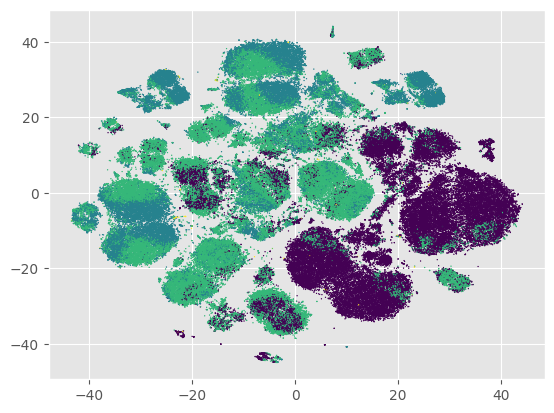

In [ ]:
from sklearn.cluster import KMeans

n_clusters = 10
kmeans = KMeans(n_clusters, random_state=42).fit(X)

plt.scatter(y_tsne[:,0], y_tsne[:, 1], c=kmeans.labels_ , s=0.2)

## DBSCAN

#### Clustering after dimensionality reduction

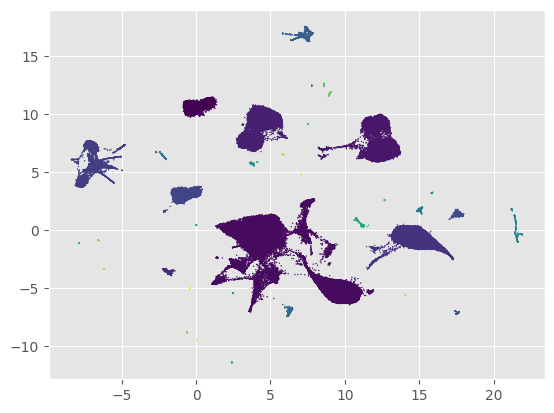

In [ ]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(0.5).fit(y_umap)

plt.scatter(y_umap[:,0], y_umap[:, 1], c=dbscan.labels_, s=0.2)